# Keyword Spotting (KWS) Application Architecture

## 1. Major workflow steps

- Step 1 Data collection
For Keyword Spotting we need a dataset aligned to individual words that includes thousands of examples which are representative of real world audio (e.g., including background noise).

- Step 2: Data Preprocessing
For efficient inference we need to extract features from the audio signal and classify them using a NN. To do this we convert analog audio signals collected from microphones into digital signals that we then convert into spectrograms which you can think of as images of sounds.

- Step 3: Model Design
In order to deploy a model onto our microcontroller we need it to be very small. We explore the tradeoffs of such models and just how small they need to be (hint: it’s tiny)!

- Step 4: Training
We will train our model using standard training techniques explored in Course 1 and will add new power ways of analyzing your training results, confusion matrices. You will get to train your own keyword spotting model to recognize your choice of words from our dataset. You will get to explore just how accurate (or not accurate) your final model can be!

- Step 5: Evaluation
We will then explore what it means to have an accurate model and why your training/validation/test error may be different from the accuracy experienced by users.



## 2. Data Collection

- There is a lot of work that goes into designing a good dataset for keyword spotting. 
    - This is true for all applications of TinyML. 
    - The requirements for different applications (and thus the data that needs to be collected) can vary drastically even for the same kinds of inputs. In fact, even for the same keyword deployed into different environments!

- It is not possible to come up with hard and fast rules for how to design a good dataset. Some considerations are discussed below. 
    - Who are the anticipated end users? It is important to understand who the end users might be as they may engage with the application differently and may present different kinds of challenges for how you need to design the application and what data you will need to collect. For example:
        - What languages will they speak? 
        - What accents will they have? 
        - Will they use slang or formal diction?
        - Will the users speak clearly?
    - In what environments will the users employ the application? Imagine a Keyword Spotting device. Is it placed in a quiet room where it can hear you clearly? Or is it placed right next to your TV in the living room? The environment can greatly affect the quality and type of audio that can be collected, as well as the amount of additional sounds that must be accounted for. For example:
        - How much background noise do we expect?
        - Who/how many people will be talking in the environment?
        - How far will the users be from the device and sources of noise?
        - Will the user be stressed vs. calm vs. panicked?
        - Will the user use different volumes of voice (whispered/normal/loud/shouted)?
        - How likely is it that these keywords may be triggered unintentionally during conversation?
    - What are the goals for using the application? How will this impact the requirements of the ML model's performance?
        - Depending on the goals of the application, model errors can either have very little consequences, or they can be catastrophic. This can directly impact how robust of a data collection scheme you need to implement. For example consider the difference between these three scenarios:
            - The user is trying to turn the thermostat up/down
            - The user is trying to arm/disarm a security system
            - The user is trying to play their favorite playlist from a smart speaker
- Given all of these previously mentioned factors here a short checklist to consider when implementing your final data collection scheme:
    - What custom keywords will you select?
    - What background noise samples do you need to collect to augment your dataset so that the trained model is robust?
    - What other words do you need to collect to ensure the model learns the difference between them and your keywords? It is important to collect other words so that the model can learn your particular word and not simply the general sounds of humans talking!
    - How much data will you need to collect? We all know more is better (usually), but you also live in the real world with time constraints so how much do you think will be enough?
- In what environments will you collect these samples?
    - Example dataset
        - [Pete Warden's Speech Command Dataset](https://paperswithcode.com/paper/speech-commands-a-dataset-for-limited)

- For Mac

~~~bash
conda activate tf
brew install portaudio
pip install pyaudio
pip install tensorflow_io
pip install python_speech_features
~~~

In [ ]:
import pyaudio
import wave
from io import BytesIO

def record_audio_to_variable(record_seconds=5, 
                             rate=44100, 
                             chunk=1024, 
                             channels=1):
    """
    Records audio from the default microphone for `record_seconds` seconds
    and returns the audio data as WAV bytes (i.e., a complete WAV file in memory).
    """
    FORMAT = pyaudio.paInt16
    audio_interface = pyaudio.PyAudio()

    # Open the microphone stream
    stream = audio_interface.open(
        format=FORMAT,
        channels=channels,
        rate=rate,
        input=True,
        frames_per_buffer=chunk
    )

    print("Recording...")
    frames = []

    # Capture data from the mic for the specified duration
    for _ in range(int(rate / chunk * record_seconds)):
        data = stream.read(chunk)
        frames.append(data)

    print("Done recording!")

    # Stop & close the stream
    stream.stop_stream()
    stream.close()
    audio_interface.terminate()

    # Combine all frames into a single bytes object and write to an in-memory WAV
    wav_io = BytesIO()
    with wave.open(wav_io, 'wb') as wf:
        wf.setnchannels(channels)
        wf.setsampwidth(audio_interface.get_sample_size(FORMAT))
        wf.setframerate(rate)
        wf.writeframes(b''.join(frames))

    # Reset buffer pointer to start
    wav_io.seek(0)

    # Return the entire WAV file as bytes
    return wav_io.read()


In [21]:
from scipy.io.wavfile import read as wav_read
import io
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
from python_speech_features import mfcc
from matplotlib import cm
import librosa

In [12]:
def get_audio(seconds):
    output = record_audio_to_variable(record_seconds=seconds)
    riff_chunk_size = len(output) - 8

    # Break up the chunk size into four bytes, held in b.
    q = riff_chunk_size
    b = []
    for i in range(4):
        q, r = divmod(q, 256)
        b.append(r)

    # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
    riff = output[:4] + bytes(b) + output[8:]

    sr, audio = wav_read(io.BytesIO(riff))
    return audio, sr

In [ ]:
# Say the word YES quietly
audio_yes_quiet, sr_yes_quiet = get_audio(2)
print("DONE")

Recording...
Done recording!
DONE


In [ ]:
# Say the word YES loudly
audio_yes_loud, sr_yes_loud = get_audio(2)
print("DONE")

Recording...
Done recording!
DONE


In [ ]:
# Say the word NO loudly
audio_no_loud, sr_no_loud = get_audio(2)
print("DONE")

Recording...
Done recording!
DONE


In [ ]:
# Say the word NO quietly
audio_no_quiet, sr_no_quiet = get_audio(3)
print("DONE")

Recording...
Done recording!
DONE


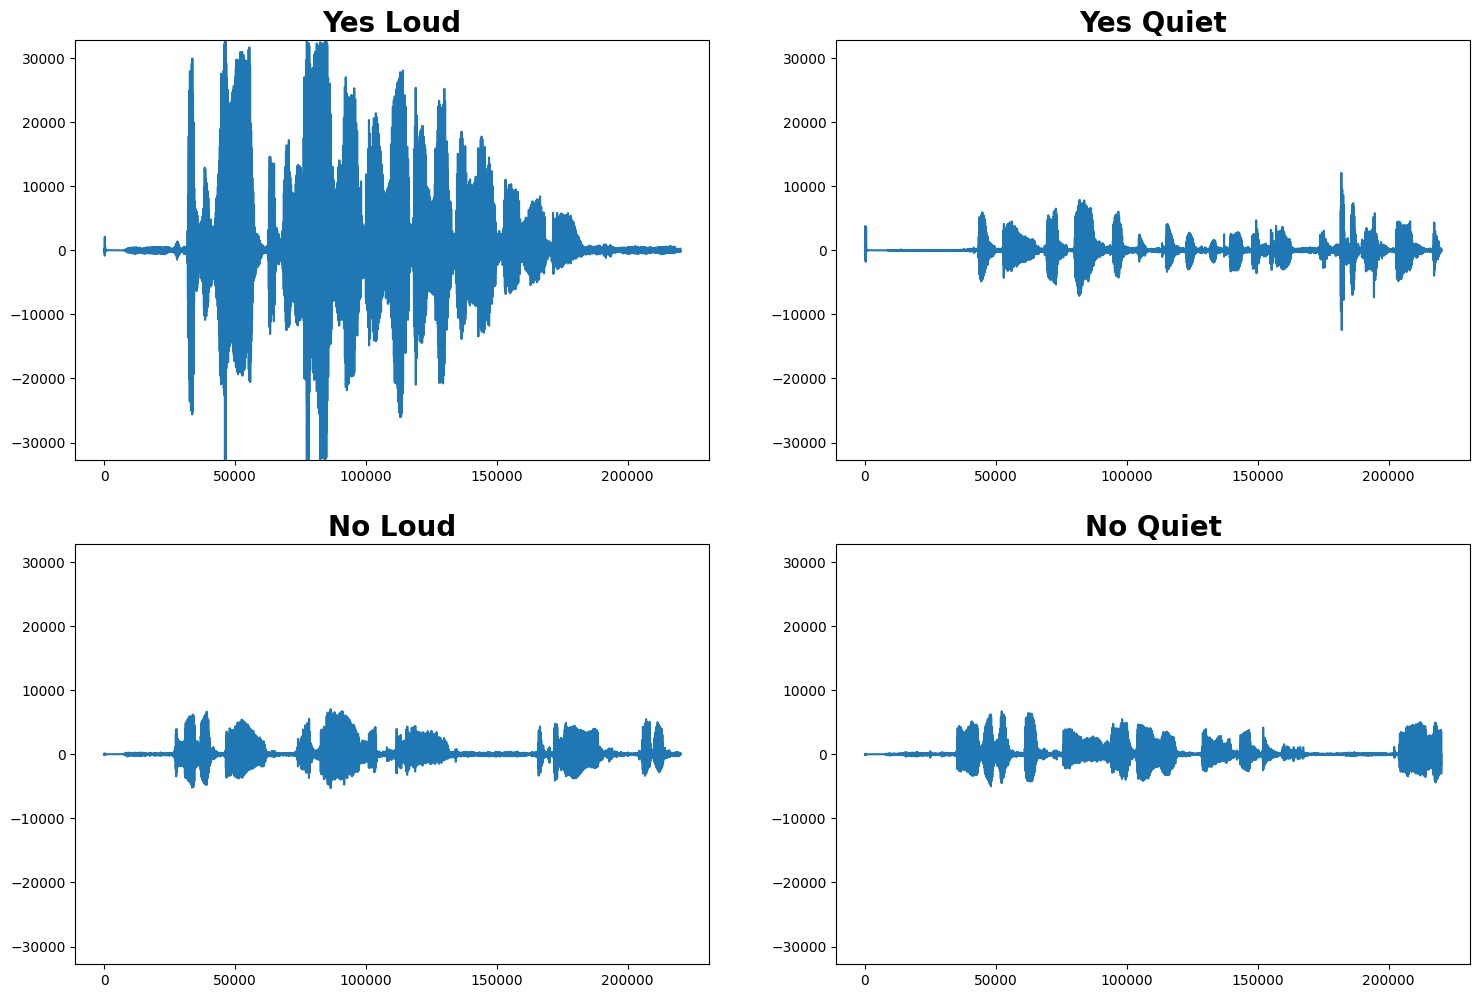

In [17]:
# Plot the figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
max_val = max(np.append(np.append(np.append(audio_yes_loud,audio_yes_quiet),audio_no_loud),audio_no_quiet))
ax1.plot(audio_yes_loud)
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax1.set_ylim(-max_val, max_val)
ax2.plot(audio_yes_quiet)
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax2.set_ylim(-max_val, max_val)
ax3.plot(audio_no_loud)
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax3.set_ylim(-max_val, max_val)
ax4.plot(audio_no_quiet)
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
ax4.set_ylim(-max_val, max_val)
fig.set_size_inches(18,12)

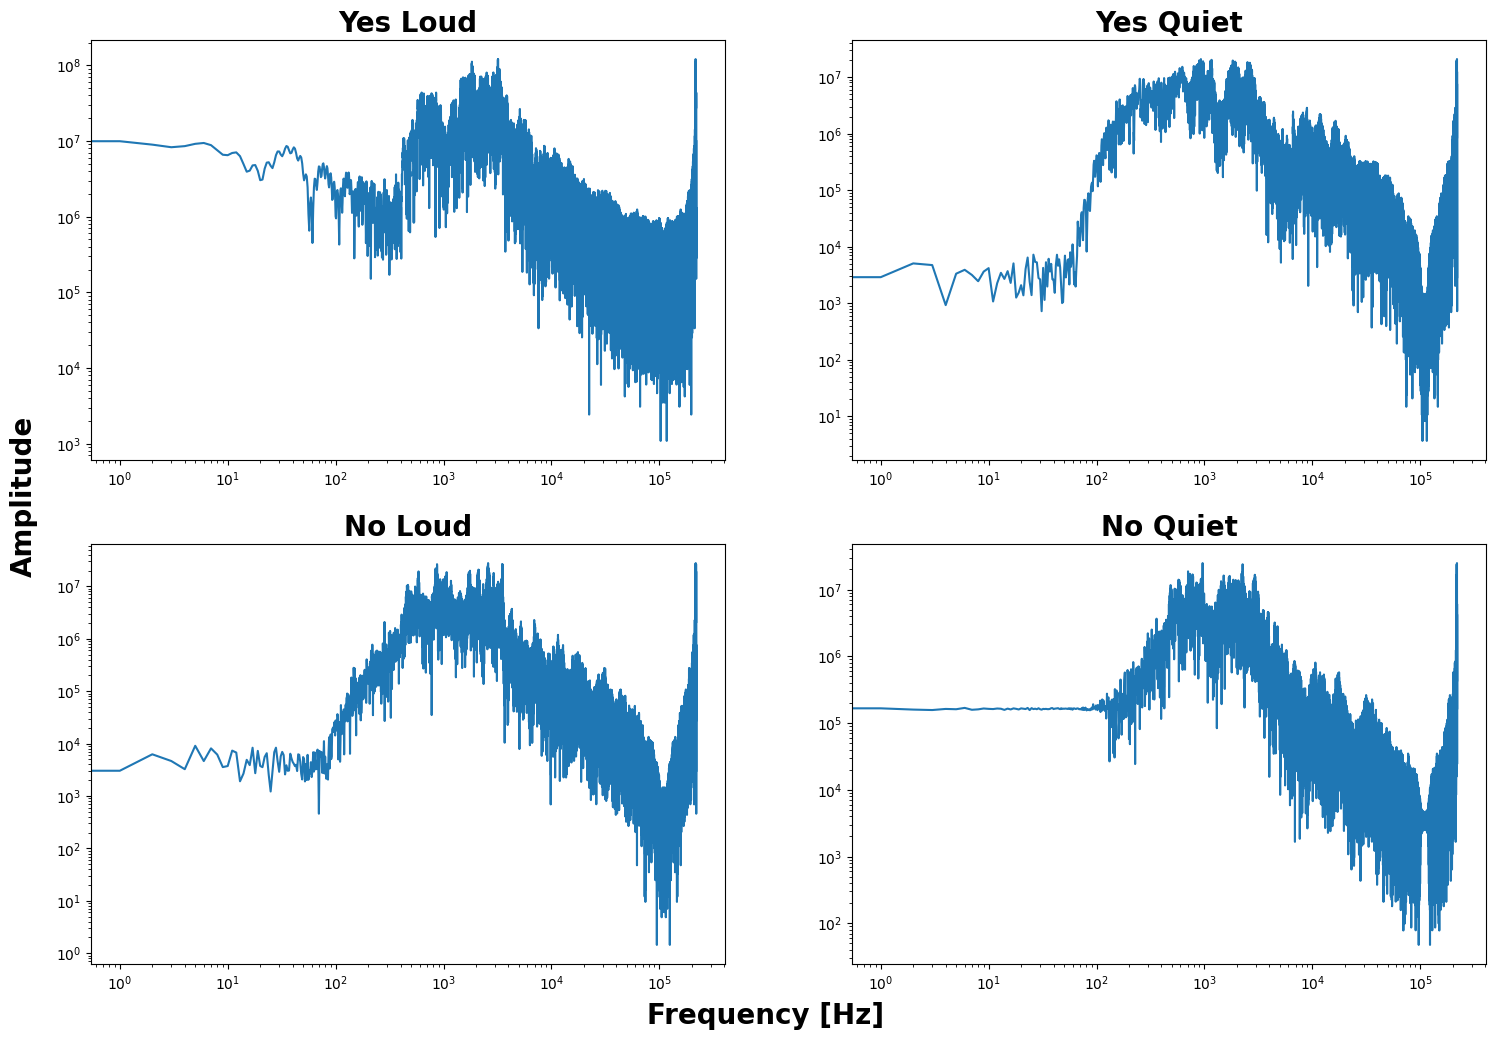

In [18]:
#Adapted from https://makersportal.com/blog/2018/9/13/audio-processing-in-python-part-i-sampling-and-the-fast-fourier-transform
# compute the FFT and take the single-sided spectrum only and remove imaginary part
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ft_audio_yes_loud = np.abs(2*np.fft.fft(audio_yes_loud))
ft_audio_yes_quiet = np.abs(2*np.fft.fft(audio_yes_quiet))
ft_audio_no_loud = np.abs(2*np.fft.fft(audio_no_loud))
ft_audio_no_quiet = np.abs(2*np.fft.fft(audio_no_quiet))

# Plot the figure
ax1.plot(ft_audio_yes_loud)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax2.plot(ft_audio_yes_quiet)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax3.plot(ft_audio_no_loud)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax4.plot(ft_audio_no_quiet)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
fig.set_size_inches(18,12)
fig.text(0.5, 0.06, 'Frequency [Hz]', {'fontsize':20, 'fontweight':'bold'}, ha='center');
fig.text(0.08, 0.5, 'Amplitude', {'fontsize':20, 'fontweight':'bold'}, va='center', rotation='vertical');

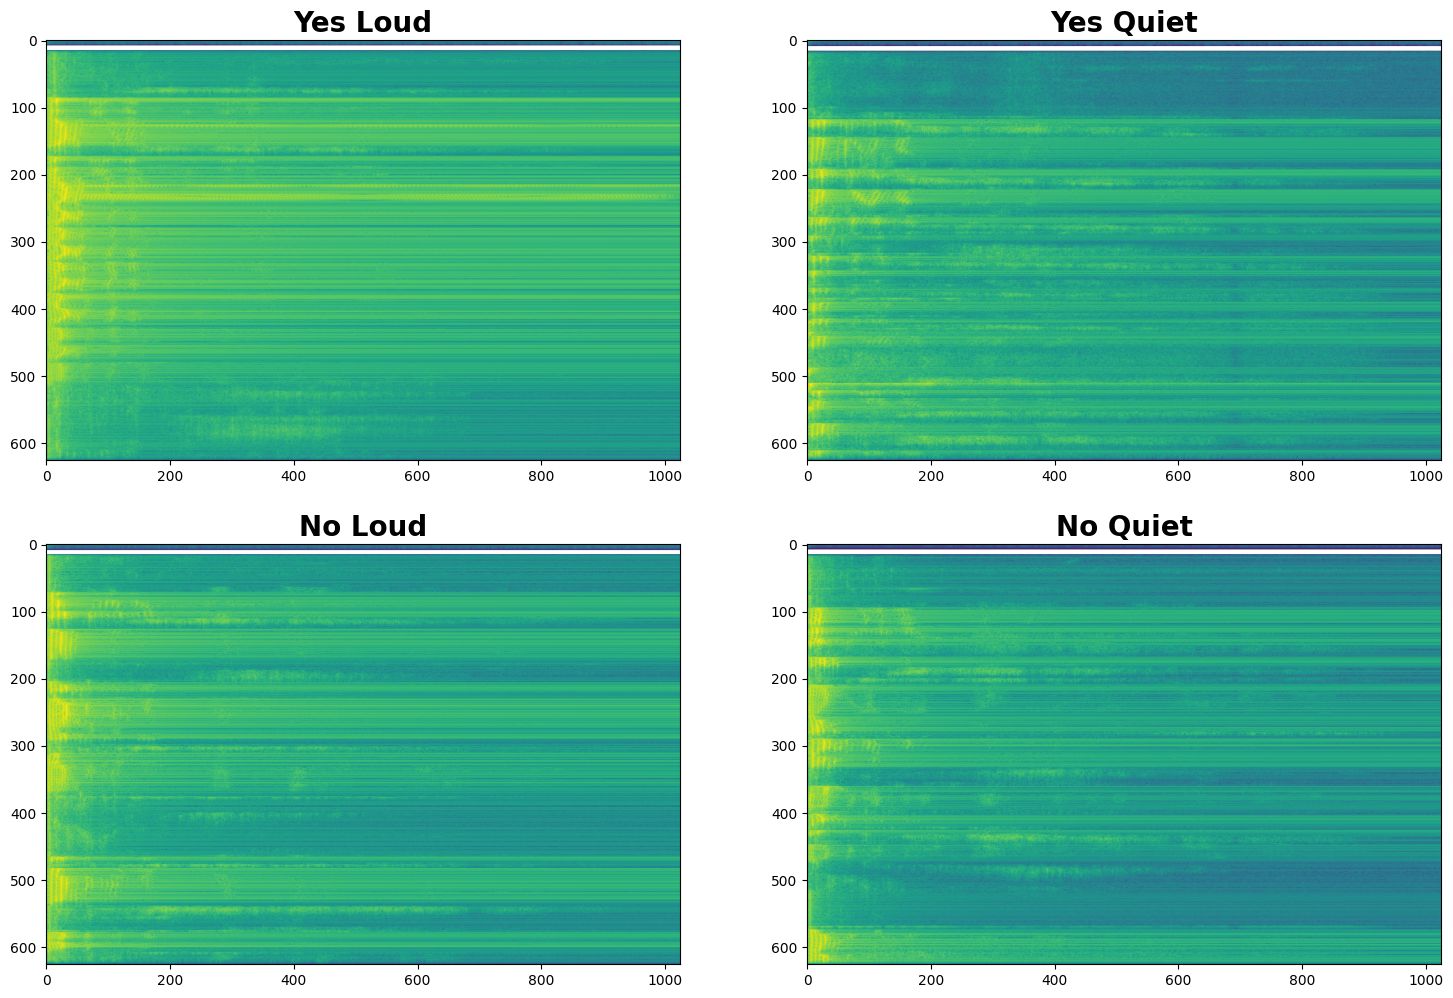

In [19]:
# Convert to spectrogram and display
# adapted from https://aruno14.medium.com/comparaison-of-audio-representation-in-tensorflow-b6c33a83d77f
spectrogram_yes_loud = tfio.audio.spectrogram(audio_yes_loud/1.0, nfft=2048, window=len(audio_yes_loud), stride=int(sr_yes_loud * 0.008))
spectrogram_yes_quiet = tfio.audio.spectrogram(audio_yes_quiet/1.0, nfft=2048, window=len(audio_yes_quiet), stride=int(sr_yes_quiet * 0.008))
spectrogram_no_loud = tfio.audio.spectrogram(audio_no_loud/1.0, nfft=2048, window=len(audio_no_loud), stride=int(sr_no_loud * 0.008))
spectrogram_no_quiet = tfio.audio.spectrogram(audio_no_quiet/1.0, nfft=2048, window=len(audio_no_quiet), stride=int(sr_no_quiet * 0.008))

# Plot the figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ax1.imshow(tf.math.log(spectrogram_yes_loud).numpy(), aspect='auto')
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax2.imshow(tf.math.log(spectrogram_yes_quiet).numpy(), aspect='auto')
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax3.imshow(tf.math.log(spectrogram_no_loud).numpy(), aspect='auto')
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax4.imshow(tf.math.log(spectrogram_no_quiet).numpy(), aspect='auto')
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
fig.set_size_inches(18,12)

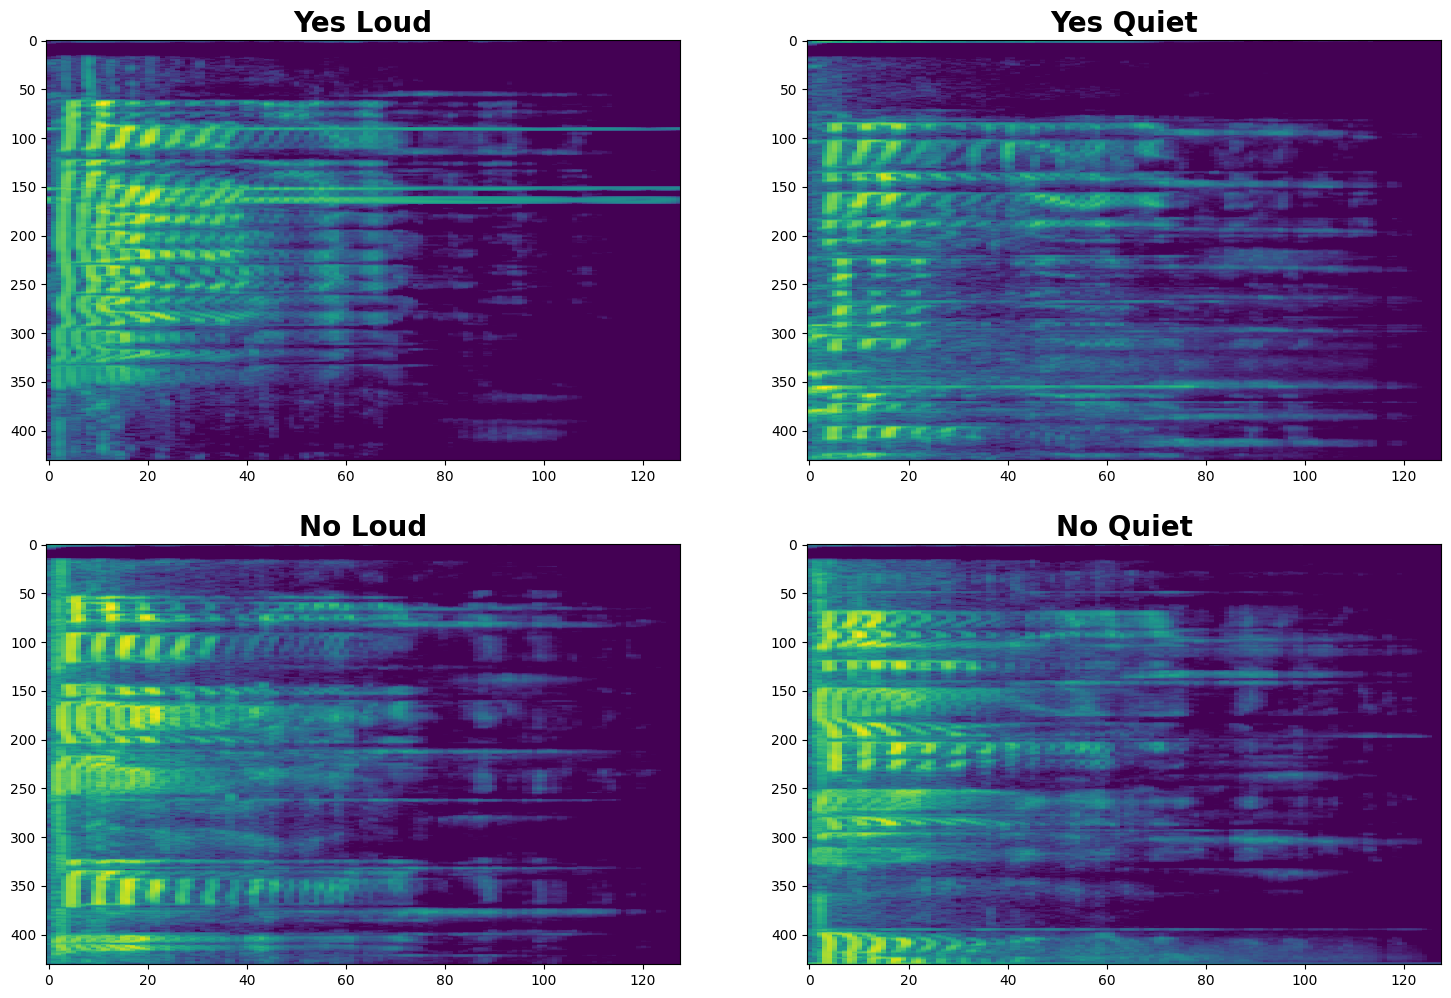

In [22]:
# Convert to MFCC using the Mel Scale
# adapted from: https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
mfcc_yes_loud = librosa.power_to_db(librosa.feature.melspectrogram(
    y=np.float32(audio_yes_loud), sr=sr_yes_loud, n_fft=2048, hop_length=512, n_mels=128), ref=np.max)
mfcc_yes_quiet = librosa.power_to_db(librosa.feature.melspectrogram(
    y=np.float32(audio_yes_quiet), sr=sr_yes_quiet, n_fft=2048, hop_length=512, n_mels=128), ref=np.max)
mfcc_no_loud = librosa.power_to_db(librosa.feature.melspectrogram(
    y=np.float32(audio_no_loud), sr=sr_no_loud, n_fft=2048, hop_length=512, n_mels=128), ref=np.max)
mfcc_no_quiet = librosa.power_to_db(librosa.feature.melspectrogram(
    y=np.float32(audio_no_quiet), sr=sr_no_quiet, n_fft=2048, hop_length=512, n_mels=128), ref=np.max)

# Plot the figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ax1.imshow(np.swapaxes(mfcc_yes_loud, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax1.set_ylim(ax1.get_ylim()[::-1])
ax2.imshow(np.swapaxes(mfcc_yes_quiet, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax2.set_ylim(ax2.get_ylim()[::-1])
ax3.imshow(np.swapaxes(mfcc_no_loud, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax3.set_ylim(ax3.get_ylim()[::-1])
ax4.imshow(np.swapaxes(mfcc_no_quiet, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
ax4.set_ylim(ax4.get_ylim()[::-1])
fig.set_size_inches(18,12)